In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split

In [3]:
data = pd.read_csv('titanic_train.csv')

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Значение признаков :
- `Sex` - Пол пассажира
- `Name` - Имя пассажира
- `PassengerId` - ID пассажира
- `Pclass` - Класс билета *(принимает значения **1** = 1st, **2** = 2nd, **3** = 3rd)*
- `Age` - Возраст пассажира 
- `SibSp` - Number of siblings / spouses aboard the Titanic
- `Parch` - Number of parents / children aboard the Titanic
- `Ticket` - Номер билета 
- `Fare` - Цена билета 
- `Cabin` - Номер кабины пассажира 
- `Embarked` - Порт высадки *(принимает значения **C** = Cherbourg, **Q** = Queenstown, **S** = Southampton)*


Значение целевой переменной :
- `Survived` - Выжил ли он *(принимает значения **1** и **0**)*


Столбцы `name`, `ticket`, `cabin`, `PassengerId` не помогут нам при решении задачи прогнозирования, поэтому уберем их 

Первым делом заменим пол на дамми и Порт высадки на дамми переменные. Разберемся с нулями у AGE.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
avg_age = data.Age.mean()
column = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']

data.Sex.replace(['male','female'],[1,0], inplace=True)

data.Embarked.fillna('None',  inplace = True)
data = pd.get_dummies(data, columns=['Embarked'])

data.Age.fillna(avg_age, inplace=True)

Y = data.Survived
X = data[column]

X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22.0,1,0,7.2500,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0
2,3,0,26.0,0,0,7.9250,0,0,1
3,1,0,35.0,1,0,53.1000,0,0,1
4,3,1,35.0,0,0,8.0500,0,0,1


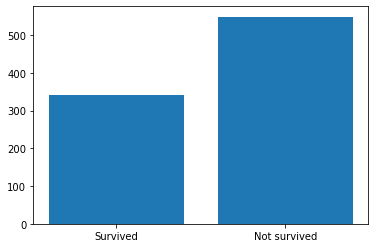

Survived 38.38%


In [7]:
index = ['Survived', 'Not survived']
values = [sum(Y), len(Y) - sum(Y)]
plt.bar(index,values)
plt.show()
print(f'Survived {sum(Y)/len(Y):.2%}')

Выборки достаточно сбалансированны, поэтому будет считаться метрика `Accuracy`

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=13)

In [9]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


scaler_train = StandardScaler()
scaler_train.fit(X_train)
X_train = scaler_train.transform(X_train)
X_test = scaler_train.transform(X_test)

___
## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

In [47]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(f'accuracy logistic regression = {accuracy_score(y_test, pred):.3%}')

accuracy logistic regression = 80.269%


___
## SVM

In [11]:
from sklearn.svm import SVC

In [12]:
clf = SVC()

clf.fit(X_train, y_train)
y_pred_sgdclf = clf.predict(X_test)
print(f'accuracy SVM = {accuracy_score(y_test, y_pred_sgdclf):.3%}')

accuracy SVM = 83.408%


___
## Decision Tree 

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
clf = DecisionTreeClassifier(random_state=13)
clf.fit(X_train, y_train)
y_pred_dt = clf.predict(X_test)

print(f'accuracy = {accuracy_score(y_test, y_pred_dt):.3%}')

accuracy = 78.924%


___
# Беггинг

In [15]:
res = 0.1
N = 200
clf = DecisionTreeClassifier()
for i in range(N):
    ind = np.random.choice(np.arange(X_train.shape[0]),
                           size = X_train.shape[0], replace = True).reshape(-1).tolist()
    clf.fit(X_train[ind], np.array(y_train)[ind])
    y_pred_beg = clf.predict(X_test)
    res = max(res, accuracy_score(y_test, y_pred_beg))

In [16]:
print(f'accuracy = {res:.3%}')

accuracy = 82.960%


Беггинг через sklearn

In [17]:
from sklearn.ensemble import BaggingClassifier

In [18]:
bag_clf = BaggingClassifier( DecisionTreeClassifier(), n_estimators= 200, max_samples=200)
bag_clf.fit(X_train, y_train)
y_pred_begging = bag_clf.predict(X_test)

print(f'accuracy Bagging = {accuracy_score(y_test, y_pred_begging):.3%}')

accuracy Bagging = 81.614%


___
# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
clf = RandomForestClassifier(n_estimators=500, max_features='sqrt')
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

print(f'accuracy Random Forest = {accuracy_score(y_test, y_pred_rf):.3%}')

accuracy Random Forest = 79.821%


<AxesSubplot:xlabel='importances', ylabel='name'>

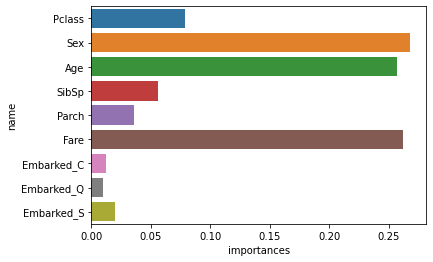

In [21]:
feature_imp = pd.DataFrame({'importances': clf.feature_importances_, 
                            'name':['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']})
sns.barplot(x="importances", y="name", data=feature_imp)

___
# Voting Classifier

In [22]:
from sklearn.ensemble import VotingClassifier

In [23]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier(n_estimators=500, max_features='sqrt')
svm_clf = SVC()

voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')

voting_clf.fit(X_train,y_train)
y_pred_vot = voting_clf.predict(X_test)

print(f'accuracy Voting Classifier = {accuracy_score(y_test, y_pred_vot):.3%}')

accuracy Voting Classifier = 82.511%


In [24]:
accuracy_basic_models = []
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=None)
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', SVC(probability=True))]

models = [(LogisticRegression(),'Logistic Regression'), 
          (SVC(),'SVM'), 
          (DecisionTreeClassifier(),'Decision Tree'), 
          (RandomForestClassifier(n_estimators=100, max_features='sqrt'),'Random Forest'),
          (VotingClassifier(estimators=estimators, voting='soft'), 'Voting classifier')]

for model, name in models:
    scores = cross_val_score(model , X, Y, cv = kf)
    accuracy_basic_models.append((name, round(scores.mean()*100,2), round(scores.std(),3)))
    
basic_models = pd.DataFrame(data = accuracy_basic_models, columns = ['model','accuracy','std'])
basic_models

,model,accuracy,std
0,Logistic Regression,79.57,0.028
1,SVM,82.94,0.023
2,Decision Tree,78.56,0.032
3,Random Forest,80.81,0.024
4,Voting classifier,82.60,0.031


Voting classifier дает примерно те же результаты. Лучший результат у SVM. Попробую его улучшить

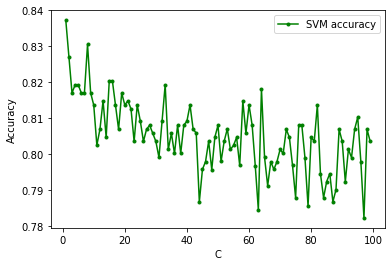

In [25]:
C = np.array([i for i in range(1,100)]) 
accur = []

for c in C:
    model = SVC(C = c)
    scores = cross_val_score(model , X, Y, cv = kf)
    accur.append(scores.mean())
    
plt.plot(C, accur, marker='.', label='SVM accuracy', color='green')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

C = 1 лучший вариант, те несильно штрафуем за ошибку.

___
## Gradient Boosting

In [26]:
from catboost import CatBoostClassifier 
from lightgbm import LGBMClassifier

In [27]:
clf = CatBoostClassifier(iterations=300, logging_level='Silent', random_state=13)
clf.fit(X_train, y_train)

y_pred_gb = clf.predict(X_test)

print(f'accuracy Gradient Boosting = {accuracy_score(y_test, y_pred_gb):.3%}')

accuracy Gradient Boosting = 82.063%


In [28]:
clf = LGBMClassifier(n_estimators=300, random_state=13)
clf.fit(X_train, y_train)

y_pred_gbm = clf.predict(X_test)

print(f'accuracy Gradient Boosting GBM = {accuracy_score(y_test, y_pred_gbm):.3%}')

accuracy Gradient Boosting GBM = 80.717%


In [29]:
accuracy_basic_models = []
models = [(CatBoostClassifier(iterations=300, logging_level='Silent'),'Catboost'), 
          (LGBMClassifier(n_estimators=300), 'lightgbm')]

for model, name in models:
    scores = cross_val_score(model , X, Y, cv = kf)
    accuracy_basic_models.append((name, round(scores.mean()*100,2), round(scores.std(),3)))
    
basic_models = pd.DataFrame(data = accuracy_basic_models, columns = ['model','accuracy','std'])
basic_models

,model,accuracy,std
0,Catboost,81.82,0.014
1,lightgbm,80.58,0.021


Catboost неплохо себя показывает. Нужно подумать над гиперпараметрами тут.

Гиперпараметры: 
* глубина базовых деревьев `max_depth`
* число деревьев N - число итераций бустинга `n_estimators`
* скорость обучения `learning_rate`
* число признаков при построении одного дерева `feature_fraction`

Начинать настройку можно с самых главных параметров: learning_rate и n_estimators. Обычно один из них фиксируют, а другой подбирают (например, фиксируют n_estimators=1000 и подбирают learning_rate). Следующим по важности является max_depth.

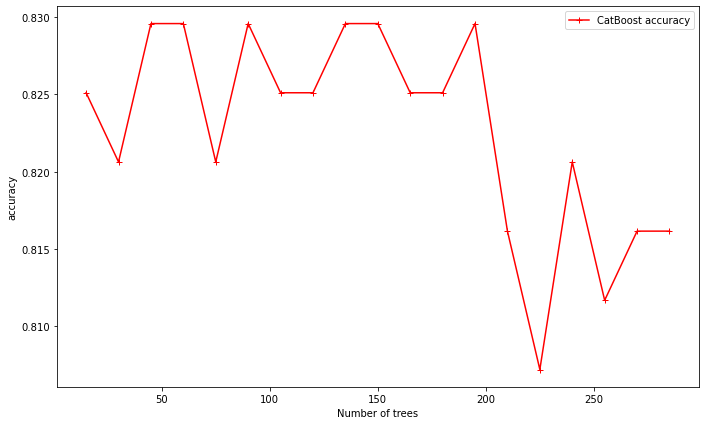

In [30]:
n_trees = np.array([i for i in range(1,20)]) * 15
accuracy_cbm = []

for n in n_trees:
    cbm = CatBoostClassifier(n_estimators=n, logging_level="Silent")
    cbm.fit(X_train, y_train)
    accuracy_cbm.append(accuracy_score(y_test, cbm.predict(X_test)))
    
plt.figure(figsize=(11.5, 7))
plt.plot(n_trees, accuracy_cbm, marker='+', label='CatBoost accuracy', color='red')
plt.xlabel('Number of trees')
plt.ylabel('accuracy')
plt.legend()

plt.show()

150 - в цело лучшее значение получается

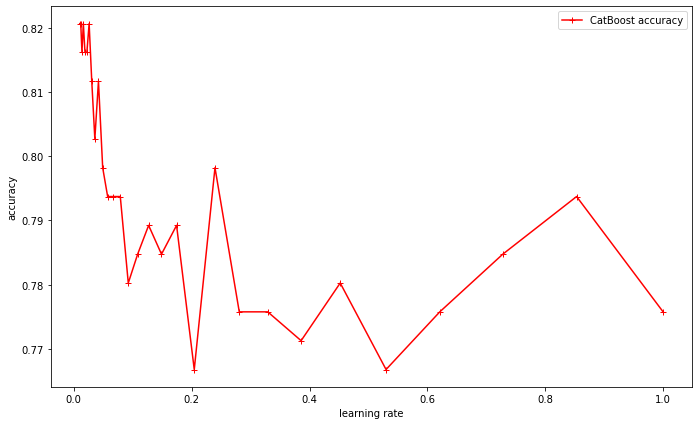

In [31]:
learn_rate = np.geomspace(0.01, 1, 30)
accuracy_cbm = []

for r in learn_rate:
    cbm = CatBoostClassifier(n_estimators=400,learning_rate=r, logging_level="Silent")
    cbm.fit(X_train, y_train)
    accuracy_cbm.append(accuracy_score(y_test, cbm.predict(X_test)))
    
plt.figure(figsize=(11.5, 7))
plt.plot(learn_rate, accuracy_cbm, marker='+', label='CatBoost accuracy', color='red')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.legend()

plt.show()

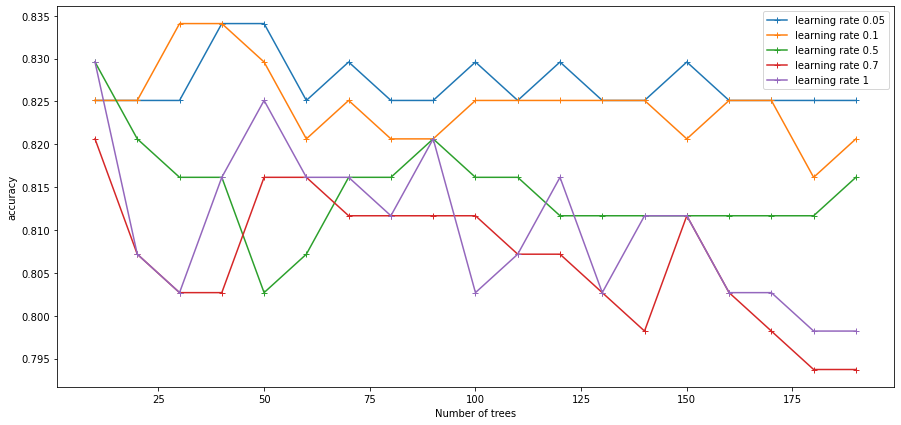

In [32]:
n_trees = np.array([i for i in range(1,20)]) * 10
learning_rate = [0.05,0.1,0.5,0.7,1]
accuracy_cbm = []
lear_acc = []

for l in learning_rate:
    lear_acc = []
    for n in n_trees:
        cbm = CatBoostClassifier(n_estimators=n,learning_rate=l, logging_level="Silent")
        cbm.fit(X_train, y_train)
        lear_acc.append(accuracy_score(y_test, cbm.predict(X_test)))
    accuracy_cbm.append((l, lear_acc))   

plt.figure(figsize=(15, 7))
plt.plot(n_trees, accuracy_cbm[0][1], marker='+', label=f'learning rate {accuracy_cbm[0][0]}')
plt.plot(n_trees, accuracy_cbm[1][1], marker='+', label=f'learning rate {accuracy_cbm[1][0]}')
plt.plot(n_trees, accuracy_cbm[2][1], marker='+', label=f'learning rate {accuracy_cbm[2][0]}')
plt.plot(n_trees, accuracy_cbm[3][1], marker='+', label=f'learning rate {accuracy_cbm[3][0]}')
plt.plot(n_trees, accuracy_cbm[4][1], marker='+', label=f'learning rate {accuracy_cbm[4][0]}')
plt.xlabel('Number of trees')
plt.ylabel('accuracy')
plt.legend()

plt.show()

Видно, что лучше брать небольшой learning rate, значит и number of trees побольше 

In [ ]:
estim = CatBoostClassifier(logging_level='Silent', learning_rate=0.05)
param_grid = [
    {'max_depth' : [3,4,5,6],
     'n_estimators' : [400,500,600,700]}
]
alg_xgb_grid = GridSearchCV(estim, param_grid, cv=kf)

alg_xgb_grid.fit(X, Y)
alg_xgb_best = alg_xgb_grid.best_estimator_
print("Accuracy (xgboost auto): {} with params {}".format(alg_xgb_grid.best_score_, alg_xgb_grid.best_params_))

In [ ]:
model = CatBoostClassifier(logging_level='Silent', learning_rate=0.05, max_depth = 5, n_estimators=700)
scores = cross_val_score(model , X, Y, cv = kf)
round(scores.mean()*100,2)

Best parametrs : 
* learning rate = 0.05
* max_depth = 5
* n_estimators = 600

Снова применим Voting Classifier

In [ ]:
cmb_clf = CatBoostClassifier(logging_level='Silent', learning_rate=0.05, max_depth = 5, n_estimators=600)
svm_clf = SVC(probability=True)

model = VotingClassifier(
        estimators=[('cmb', cmb_clf), ('svc', svm_clf)], voting='hard')

scores = cross_val_score(model , X, Y, cv = kf)

print(f'accuracy Voting Classifier = {scores.mean():.2%}, {scores.std():.3f}')

___

In [ ]:
test_data = pd.read_csv('test.csv')
test_data.head()

In [ ]:
answer = test_data['PassengerId']

In [ ]:
test_data.info()

In [ ]:
avg_age = data.Age.mean()
column = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']

test_data.Sex.replace(['male','female'],[1,0], inplace=True)

test_data = pd.get_dummies(test_data, columns=['Embarked'])

test_data.Age.fillna(avg_age, inplace=True)
test_data.Fare.fillna(test_data.Fare.mean(), inplace=True)

X_test = test_data[column]

X_test.head()

In [ ]:
X_test.info()

In [ ]:
X_test.shape

In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
X_test.shape

In [ ]:
cmb_clf = CatBoostClassifier(logging_level='Silent', learning_rate=0.05, max_depth = 5, n_estimators=600)
svm_clf = SVC()

model = VotingClassifier(
        estimators=[('cmb', cmb_clf), ('svc', svm_clf)], voting='hard')

model.fit(X,Y)
y_pred = model.predict(X_test)

In [ ]:
model = CatBoostClassifier(logging_level='Silent', learning_rate=0.05, max_depth = 5, n_estimators=600)

model.fit(X,Y)
y_pred_2 = model.predict(X_test)

In [ ]:
ans = pd.DataFrame({'PassengerId' : answer.values, 'Survived' : y_pred_2})
ans.Survived = ans.Survived.astype(int)
ans.set_index('PassengerId', inplace=True)

In [ ]:
ans.to_csv('gender_submission.csv')